(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [27]:
# Load project package
@load_pkg BayesFitUtils

import Revise
import Suppressor
# Import project package
import BayesFitUtils
# Import library to list files
import Glob
# Import package to save chains into memory
import JLD2

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import Distributions
import StatsBase
import Random

# Import basic math
import LinearAlgebra

# Import libraries relevant for MCMC
import Turing
import MCMCChains
import Zygote
import ReverseDiff

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitUtils.viz.pboc_makie!()

# Bayesian inference of adaptive mutants fitness

## The fitness model

`[explanation here]`

## Loading the data

Let's begin by loading the data.

In [2]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String31,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false


# Bayesian  model using `Turing.jl`

Our objective for this section will be to implement the Bayesian model using the
probabilistic programing language that `Turing.jl` encodes.

`[explanation here]`

Let's define the model using the @model macro from `Turing.jl`

In [3]:
Turing.@model function fitness_mutants(
    logf_mut, logf_neutral, t, σ_sm, σ_σm, σ_st, σ_σt
)
    # Define parameter types
    s̲ₘ = Float32[]  # adaptive mutants fitness
    σ̲ₘ = Float32[]  # variance for adaptive mutants fitness likelihood

    s̲ₜ = Float32[]  # population mean fitness vector
    σ̲ₜ = Float32[]  # variance for population mean fitness likelihood

    ## Prior
    
    # Prior on adaptive mutants mean fitness
    s̲ₘ ~ Turing.filldist(Turing.Normal(0, σ_sm), size(logf_mut, 2))
    # Prior on variance for adaptive mutants fitness likelihood
    σ̲ₘ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σ_σm); lower=0.0 + eps()), 
        size(logf_mut, 2)
    )

    # Prior on the mean fitness
    s̲ₜ ~ Turing.filldist(Turing.Normal(0, σ_st), length(t))
    # Prior on error 
    σ̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σ_σt); lower=0.0 + eps()), 
        length(t)
    )
    
    ## Likelihood

    # Population mean fitness
    
    # Loop through neutral lineages
    for j = 1:size(logf_neutral, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_neutral[:, j]) .& .!isnan.(logf_neutral[:, j])
        # Sample
        logf_neutral[idx, j] ~ Turing.MvNormal(
            -s̲ₜ[idx], LinearAlgebra.Diagonal(σ̲ₜ[idx] .^2)
        )
    end # for

    # Adaptive mutants fitness
    
     # Loop through mutants lineages
     for j = 1:size(logf_mut, 2)
        # Define non-infinity indexes
        idx = .!isinf.(logf_mut[:, j]) .& .!isnan.(logf_mut[:, j])
        # Sample
        logf_mut[idx, j] ~ Turing.MvNormal(
            s̲ₘ[j] .- s̲ₜ[idx], 
            LinearAlgebra.I(sum(idx)) .* (σ̲ₘ[j] .^2)
        )
    end # for

    return logf_mut, logf_neutral
end # @model function

fitness_mutants (generic function with 2 methods)

Let's now extract the data.

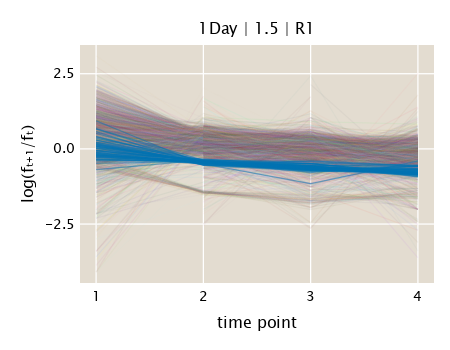

In [4]:
# Define information for data to extract
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"
# batch = "Batch1"
# hub = "1Day"
# perturbation = "28"
# rep = "R1"


# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the log freq changes
data_log = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Compute log change
    DF.append!(
        data_log, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :logf => diff(log.(d.freq)),
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(fₜ₊₁/fₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_log[.!data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_log[data_log.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        bc.logf,
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

Let's extract the data and put it into a convenient format.

In [5]:
# Extract data for mutants
logf_mut = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[.!data_log.neutral, :], :barcode)
    ]...
)
# Extract data for neutral lineages
logf_neutral = hcat(
    [
        Float32.(DF.sort(d, :time).logf)
        for d in DF.groupby(data_log[data_log.neutral, :], :barcode)
    ]...
)

4×56 Matrix{Float32}:
 -0.34545   -0.349183  -0.0599262  …   0.142053   0.0903559  -0.159051
 -0.439573  -0.430029  -0.386549      -0.466767  -0.404325   -0.335645
 -0.779961  -0.613287  -0.596358      -0.48619   -0.580775   -0.574143
 -0.579903  -0.866741  -0.768193      -0.916034  -0.819359   -0.843799

Now, we are ready to test the model. Let's run the inference for a few of the
strains.

In [6]:
Random.seed!(42)

# Define model
model = fitness_mutants(
    logf_mut[:, 1:5], 
    logf_neutral, 
    unique(data_log.time), 
    Float32(5.0), 
    Float32(1.0),
    Float32(5.0),
    Float32(1.0),
);

# Suppress warning outputs
# Suppressor.@suppress begin
    # Sample
    global chain = Turing.sample(
        model, 
        Turing.NUTS(0.65), 
        Turing.MCMCThreads(),
        1_000, 
        3, 
        progress=false
    )
# end

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       s̲ₘ[1]    0.9457    0.2611    0.0075   1802.6060   1180.0904    1.0011   ⋯
       s̲ₘ[2]   -0.0271    0.8392    0.0152   3178.4326   2031.3836    1.0006   ⋯
       s̲ₘ[3]    0.2834    0.6257    0.0123   2771.4143   1820.2795    1.0023   ⋯
       s̲ₘ[4]    0.6733    0.4976    0.0103   2514.5402   1832.1836    1.0017   ⋯
       s̲ₘ[5]    0.7442    0.3389    0.0080   2114.3751   1411.7024    1.0000   ⋯
       σ̲ₘ[1]    0.4459    0.2552    0.0065   2088.2654   1743.2152    1.0001   ⋯
       σ̲ₘ[2]    1.6460    0.4418    0.0076   3887.5014   2199.6392    1.0005   ⋯
       σ̲ₘ[3]    1.2070    0.3957    0.0074   3316.1097   2045.4217    1.0004   ⋯
       σ̲ₘ[4]    0.9527    0.3643    0.0069   3381.4237   2301.8608    1.0011   ⋯
       σ̲ₘ[5]    0.6169    0.3032    0.0064   2954.5533   2029.1012    1.0007   

Let's look at the traces for each of the walkers on each parameter.

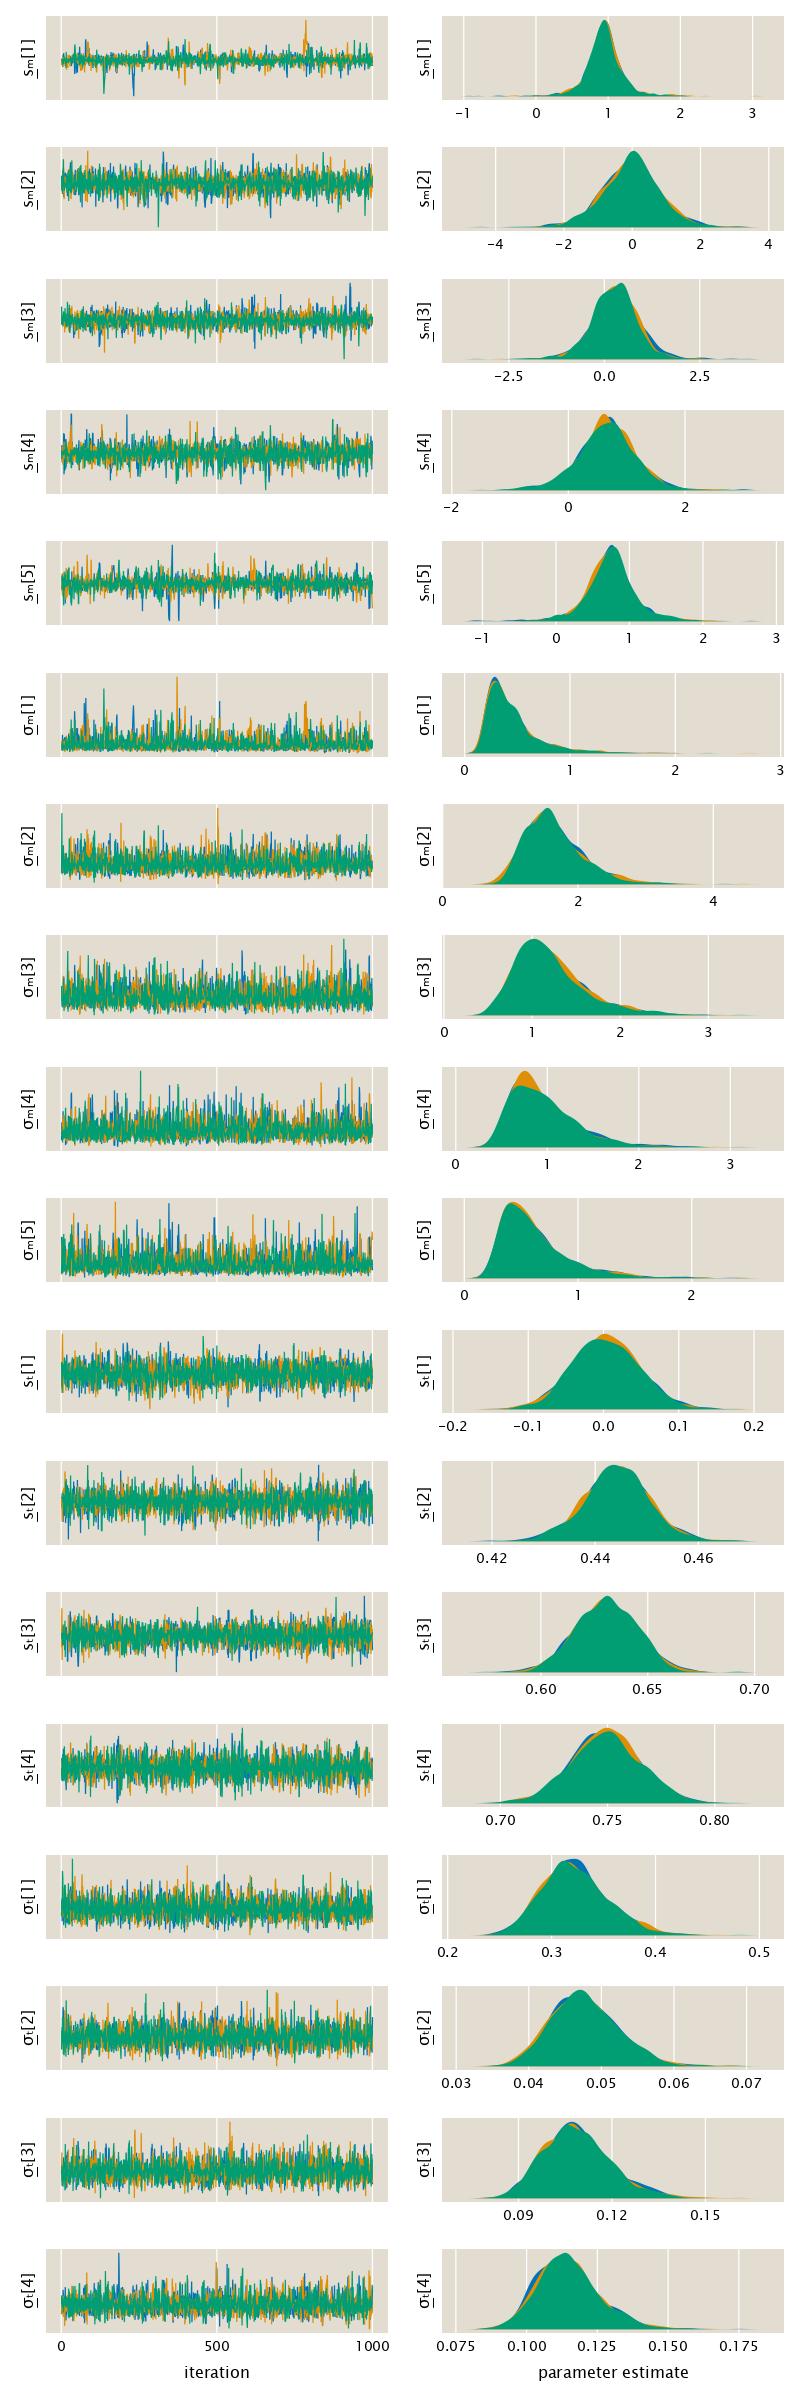

In [7]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(800, 2400))

BayesFitUtils.viz.mcmc_trace_density!(fig, chain)

fig

# Two-step inference

The inference of the entire dataset with > 4000 mutants does not scale properly,
even though, sampling for a few mutants is almost instantaneous. But we can take
advantage of the structure of our problem.

In [8]:
Turing.@model function mutant_fitness_full(
    r̲⁽ᵐ⁾, r̲⁽ᶜ⁾, α̲, σₛ, σₑ, μ_sₜ, σ_sₜ
)
    # Prior on mutant fitness s⁽ᵐ⁾
    s⁽ᵐ⁾ ~ Turing.Normal(0.0, σₛ)
    # Prior on LogNormal error σ⁽ᵐ⁾ 
    σ⁽ᵐ⁾ ~ Turing.truncated(Turing.Normal(0.0, σₑ); lower=0.0)

    # Population mean fitness values
    s̲ₜ ~ Turing.MvNormal(μ_sₜ, LinearAlgebra.Diagonal(σ_sₜ .^2))

    # Initialize array to store frequencies
    f̲⁽ᵐ⁾ = Vector{Float64}(undef, length(r̲⁽ᵐ⁾))

    # Frequency distribution for each time point
    for i in eachindex(r̲⁽ᵐ⁾)
        f̲⁽ᵐ⁾[i] ~ Turing.Beta(α̲[1] + r̲⁽ᵐ⁾[i], α̲[2] + r̲⁽ᶜ⁾[i])
    end # for
    
    # Compute frequency ratios
    γ̲⁽ᵐ⁾ = f̲⁽ᵐ⁾[2:end] ./ f̲⁽ᵐ⁾[1:end-1]

    # Sample posterior for frequency ratio. Since it is a sample over a
    # generated quantity, we must use the @addlogprob! macro
    Turing.@addlogprob! Turing.logpdf(
        Turing.MvLogNormal(
            s⁽ᵐ⁾ .- s̲ₜ,
            LinearAlgebra.I(length(s̲ₜ)) .* σ⁽ᵐ⁾^2
        ),
        γ̲⁽ᵐ⁾
    )

end # @model function

mutant_fitness_full (generic function with 2 methods)

Let's extract some example data for a particular batch.

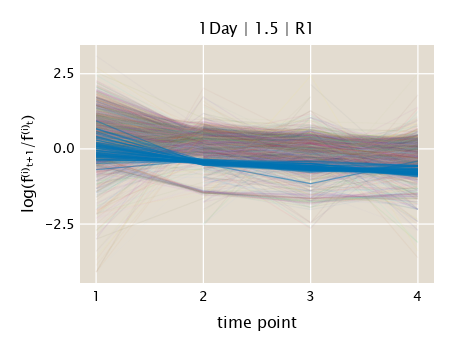

In [12]:
Random.seed!(42)

# Define information for data to extract
# Define batch
batch = "Batch2"
hub = "1Day"
perturbation = "1.5"
rep = "R1"

# Extract data. 
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep)
    ,
:]

# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Extract total counts per barcode
data_total = DF.combine(DF.groupby(data, :time), :count => sum)
# Add total count column to dataframe
DF.leftjoin!(data, data_total; on=:time)
# Add frequency column
DF.insertcols!(data, :freq => data.count ./ data.count_sum)

# Initialize dataframe to save the freq changes
data_gamma = DF.DataFrame()

# Group data by barcode
data_group = DF.groupby(data, :barcode)

# Loop through each group
for d in data_group
    # Sort data by timepoint
    DF.sort!(d, :time)
    # Compute log change
    DF.append!(
        data_gamma, 
        DF.DataFrame(
            :barcode .=> first(d.barcode),
            :time => d.time[2:end],
            :γ => d.freq[2:end] ./ d.freq[1:end-1],
            :neutral .=> first(d.neutral)
        )
    )
end # for

# Initialize figure
fig = Figure(resolution=(450, 350))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="time point",
    ylabel="log(f⁽ⁱ⁾ₜ₊₁/f⁽ⁱ⁾ₜ)",
    title="$(hub) | $(perturbation) | $(rep)"
)

# Define color palette
colors = ColorSchemes.glasbey_hv_n256

# group data by barcode
data_group = DF.groupby(data_gamma[.!data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(colors[StatsBase.sample(1:length(colors))], 0.05)
    )
end # for

# group neutral barcodes by barcode
data_group = DF.groupby(data_gamma[data_gamma.neutral, :], :barcode)
# Loop through trajectories
for bc in data_group
    # Plot trajectory
    lines!(
        log.(bc.γ),
        color=(ColorSchemes.seaborn_colorblind[1], 0.5)
    )
end # for

fig

Now, let's list the unique barcodes and extract the corresponding reads.

In [53]:
# Group data by unique mutant barcode
data_group = DF.groupby(data[.!data.neutral, :], :barcode)

# Extract total number of barcodes per timepoint
r_tot = DF.combine(DF.groupby(data, :timepoint), :count => sum)

# Extract total number of unique barcodes
n_tot = length(unique(data.barcode))

# Initialize matrix to save counts for each mutant
r = Array{Float64}(
    undef, length(data_group), 2, length(unique(data.timepoint))
)
# Loop through each unique barcode
for (i, d) in enumerate(data_group)
    # sort data by timepoint
    DF.sort!(d, :timepoint)
    # Extract data
    r[i, 1, :] = d.count
    r[i, 2, :] = r_tot.count_sum .- d.count
end # for

# Define alpha values
α = [1, n_tot - 1]

2-element Vector{Int64}:
    1
 5026

Let's now extract the parameters for the population mean fitness distributions.
These distributions were inferred with MCMC. To parametrize them, we will fit a
Normal distribution to the mean fitness traces.

In [34]:
# List mean fitness files
mean_files = Glob.glob(
    "$(git_root())/code/processing/"[2:end] *
    "mcmc_bigbatch_mutantfitness/output/1000steps_4walkers/*jld2",
    "/"
)

# Extract files for specific dataset
files = mean_files[
    occursin.(batch, mean_files) .&
    occursin.(hub, mean_files) .&
    occursin.(perturbation, mean_files) .&
    occursin.(rep, mean_files)
]

# Initialize arrays to save mean and variance for population mean fitness
µ_sₜ = Vector{Float64}(undef, length(files))
σ_sₜ = similar(µ_sₜ)

# Loop through files
for (i, f) in enumerate(files)
    # Load MCMC chain
    chain = vec(Matrix(JLD2.load(f)["chain"][1][:, :sₜ, :]))
    # Fit Normal distribution
    dist = Distributions.fit(Distributions.Normal, chain)
    # Store mean and standard deviation
    µ_sₜ[i] = Distributions.mean(dist)
    σ_sₜ[i] = Distributions.std(dist)
end # for

In [59]:
Random.seed!(42)

# Define model
model = mutant_fitness_full(
    r[1, 1, :], r[1, 2, :], α, 5.0, 5.0, μ_sₜ, σ_sₜ
)

# Sample
# # Suppress warning outputs
# Suppressor.@suppress begin
#     # Sample
chain = Turing.sample(
    model, 
    Turing.NUTS(0.65), 
    Turing.MCMCThreads(), 
    1000, 
    4, 
    progress=false
)
# end

┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190


┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/Suzsv/src/inference/hmc.jl:190


Chains MCMC chain (1000×23×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 1.44 seconds
Compute duration  = 4.49 seconds
parameters        = s⁽ᵐ⁾, σ⁽ᵐ⁾, s̲ₜ[1], s̲ₜ[2], s̲ₜ[3], s̲ₜ[4], f̲⁽ᵐ⁾[1], f̲⁽ᵐ⁾[2], f̲⁽ᵐ⁾[3], f̲⁽ᵐ⁾[4], f̲⁽ᵐ⁾[5]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

        s⁽ᵐ⁾    0.8020    0.1395    0.0048   1239.4182    912.2781    1.0325   ⋯
        σ⁽ᵐ⁾    0.1635    0.2825    0.0119     52.5605     42.4488    1.0827   ⋯
       s̲ₜ[1]   -0.1497    0.0402    0.0013    951.2410    679.6282    1.0061   ⋯
       s̲ₜ[2]    0.4417    0.0063    0.0002    905.3695   1546